Same as EffectCpt notebook but with model effCpt2.stan where I used vectors instead of arrays.

In [49]:
import sys; print(sys.executable)

/usr/bin/python3


In [50]:
import numpy as np
import os
import json
from parse_csv import parse_csv
import pandas as pd
import matplotlib.pyplot as plt
import time
import arviz as az
az.style.use('arviz-darkgrid')

import cmdstanpy

In [51]:
cwd = os.getcwd()
stan_directory = '~/.cmdstan/cmdstan-2.29.2'

## Create data file

In [52]:
amt = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
cmt = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
cObs = [109, 249, 300, 269, 360, 168, 114, 72.6, 48.3, 30.2, 26.6, 17.7, 12.4]
evid = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
iObs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
nObs = 13
nt = 14
respObs = [3.66033618662856, 9.0092202609012, 57.9465131782864, 65.2440041386484, 60.0369505104016, 
           65.7022283491566, 62.4707569775122,44.4101247531305, 29.2905126102645, 30.4521179187915, 
           25.5117593973144, 15.0679877202633, 6.29335052673625]
t = [0, 0.125, 0.25, 0.5, 0.75, 1, 2, 3, 4, 6, 8, 12, 18, 24]

data = {'amt' : amt, 'cmt': cmt, 'cObs': cObs, 'evid': evid, 
        'iObs': iObs, 'nObs': nObs, 'nt': nt, 'respObs': respObs, 'time': t}

! mkdir -p data
data_as_json = json.dumps(data, indent = 4)
with open('data/data.json', 'w') as outfile:
    outfile.write(data_as_json)

## Compile model

In [53]:
model = 'effCpt'
! cat $model*.stan

functions {

	vector expMatSolve(real t0, real t, vector init, 
						real CL, real Q, real V1, real V2, real ka, real ke0) {
 
		matrix[4, 4] K ;
		K = rep_matrix(0, 4, 4) ; 
		K[1, 1] = - ka ;
		K[2, 1] = ka ;
		K[2, 2] = - (CL/V1 + Q/V1) ;
		K[2, 3] = Q/V2 ;
		K[3, 2] = Q/V1 ;
		K[3, 3] = - Q/V2 ;
		K[4, 2] = ke0 ;
		K[4, 4] = - ke0 ;
		
		vector[4] x ;
		x = matrix_exp((t - t0) * K) * to_vector(init) ;
	   
	   	return x ;
	   	
	   	}


  matrix effCptModel(real[] time, real[] amt, int[] cmt, int[] evid,
  					real CL, real Q, real V1, real V2, real ka, real ke0) {
  					
    vector[4] init ;
    init = rep_vector(0, 4);
    
    int nt = size(time) ;
    matrix[nt, 4] result;

    for (i in 1:nt){
    
    	init = expMatSolve(time[max(1, i - 1)], time[i], init, CL, Q, V1, V2, ka, ke0) ;
    	
		if (evid[i] == 1) init[cmt[i]] = init[cmt[i]] + amt[i] ;
		
		for (j in 1:4) result[i, j] = init[j];
    }
    
    return result;
  
  }
	
// end functions block

}

data {
  int<lower 

In [54]:
! cd $stan_directory/ && make $cwd/$model && cd $cwd


--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /home/tng/Documents/PremiersEssais/EffectCpt/effCpt.o /home/tng/Documents/PremiersEssais/EffectCpt/effCpt.hpp
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/su

In [55]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=500
warm_iter=500

model=effCpt
data_input=data.json
data_output=output_${alg}_${model}

mkdir -p ${data_output}

for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [56]:
fit_foldername="output_hmc_" + model
fit_filename="output_hmc_" + model
output_dir= cwd + "/" + fit_foldername

time.sleep(15) #delay 15 sec

!tail -n2 $output_dir/*$model*out

==> /home/tng/Documents/PremiersEssais/EffectCpt/output_hmc_effCpt/output_hmc_effCpt_1.out <==
               15.084 seconds (Total)


==> /home/tng/Documents/PremiersEssais/EffectCpt/output_hmc_effCpt/output_hmc_effCpt_2.out <==
               8.767 seconds (Total)


==> /home/tng/Documents/PremiersEssais/EffectCpt/output_hmc_effCpt/output_hmc_effCpt_3.out <==
               11.994 seconds (Total)


==> /home/tng/Documents/PremiersEssais/EffectCpt/output_hmc_effCpt/output_hmc_effCpt_4.out <==
               11.357 seconds (Total)



## Outputs

In [57]:
! $stan_directory/bin/stansummary $output_dir/$fit_filename*.csv

Inference for Stan model: effCpt_model
4 chains: each with iter=(500,500,500,500); warmup=(0,0,0,0); thin=(1,1,1,1); 2000 iterations saved.

Warmup took (10, 4.5, 7.4, 8.3) seconds, 30 seconds total
Sampling took (5.0, 4.2, 4.6, 3.1) seconds, 17 seconds total

                     Mean     MCSE   StdDev       5%      50%      95%    N_Eff  N_Eff/s    R_hat

lp__             -1.4e+01  9.4e-02  2.4e+00 -1.9e+01 -1.4e+01 -1.1e+01  6.7e+02  4.0e+01  1.0e+00
accept_stat__        0.99  1.9e-03    0.019     0.95     0.99     1.00  1.1e+02  6.3e+00  1.0e+00
stepsize__           0.10  1.1e-02    0.016    0.084     0.12     0.12  2.0e+00  1.2e-01  8.0e+13
treedepth__           5.0  1.8e-01     0.54      4.0      5.0      6.0  8.8e+00  5.2e-01  1.1e+00
n_leapfrog__           38  6.1e+00       16       15       31       63  6.7e+00  4.0e-01  1.2e+00
divergent__          0.00      nan     0.00     0.00     0.00     0.00      nan      nan      nan
energy__               19  1.2e-01      3.1       14

In [58]:
#Load with parse_csv
chains = []
for ichain in range(4) :
    chains.append(parse_csv(output_dir + '/' + fit_filename + '_' + str(ichain+1) + '.csv'))
    
chains = pd.DataFrame(chains)

chains = chains.explode(column=chains.columns.tolist())
chains['n_chain'] = chains.index.copy()
chains = chains.reset_index()

num_iter = 500
n_chains = 4
chains['iter'] =  np.array([np.arange(num_iter)]*n_chains).flatten()

In [59]:
#Load with arviz
fit = az.from_cmdstan(posterior=output_dir + '/' + fit_filename + '*'  + '.csv',
                          posterior_predictive=['cObsPred', 'respObsPred'],
                          observed_data='data/data.json')
fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_uti

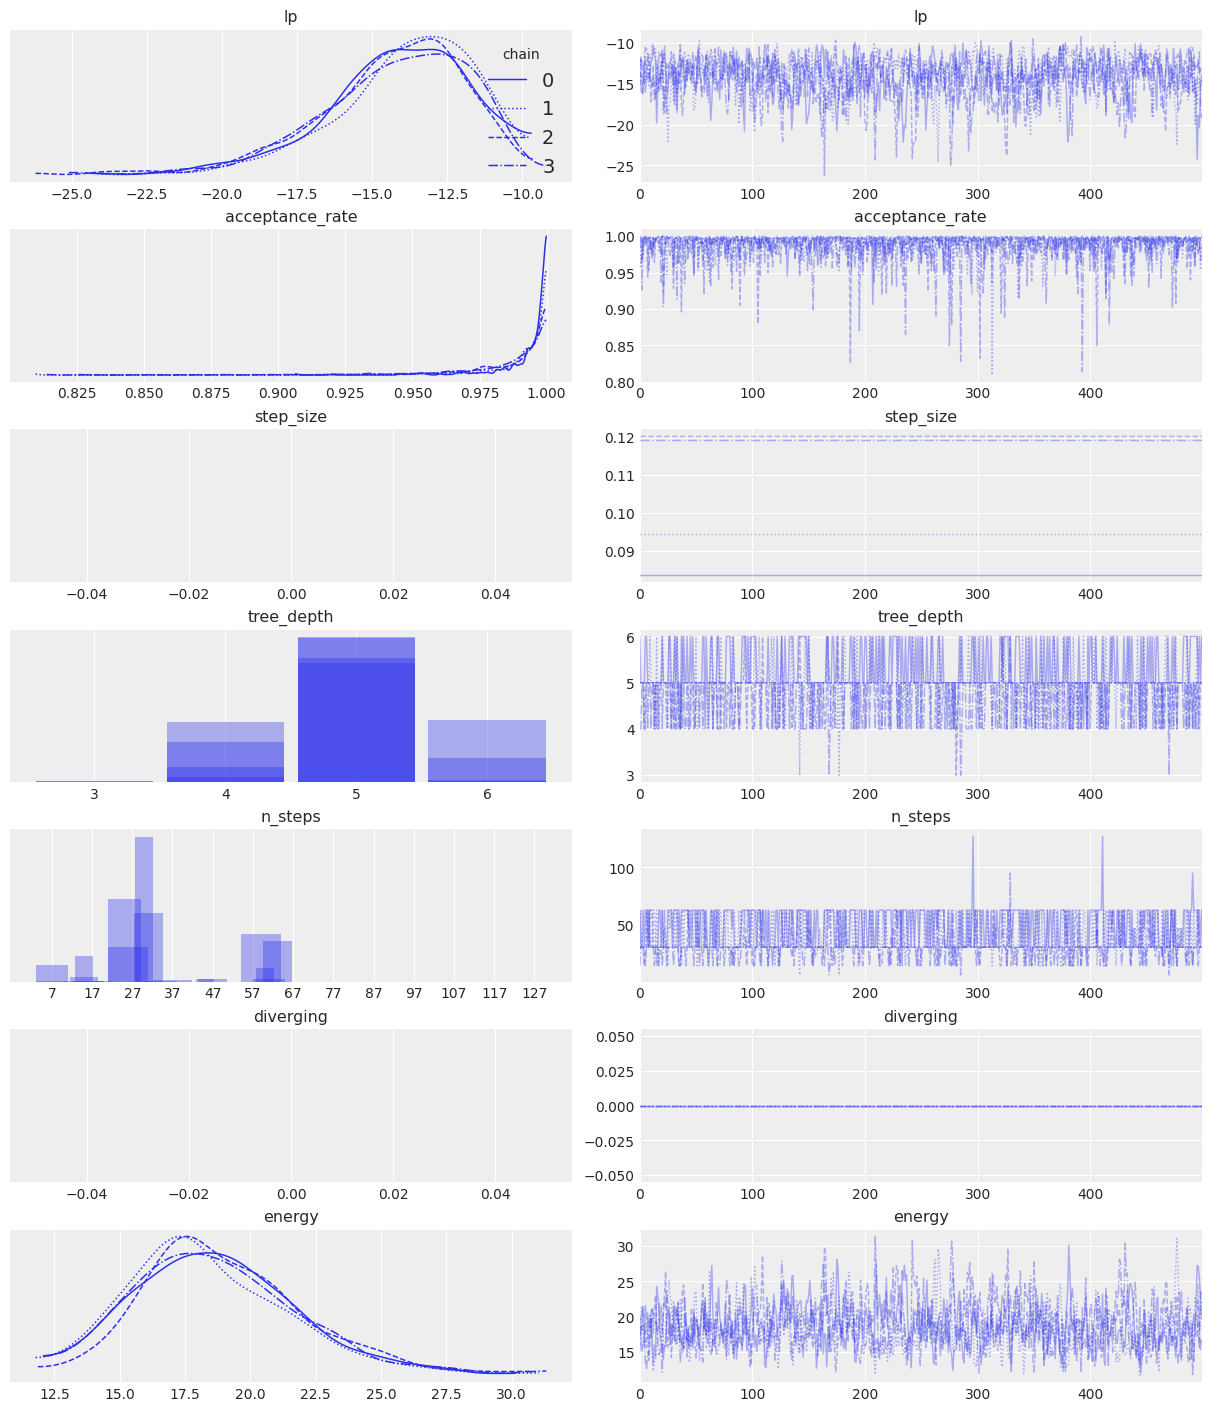

In [60]:
az.plot_trace(fit.sample_stats, legend=True);

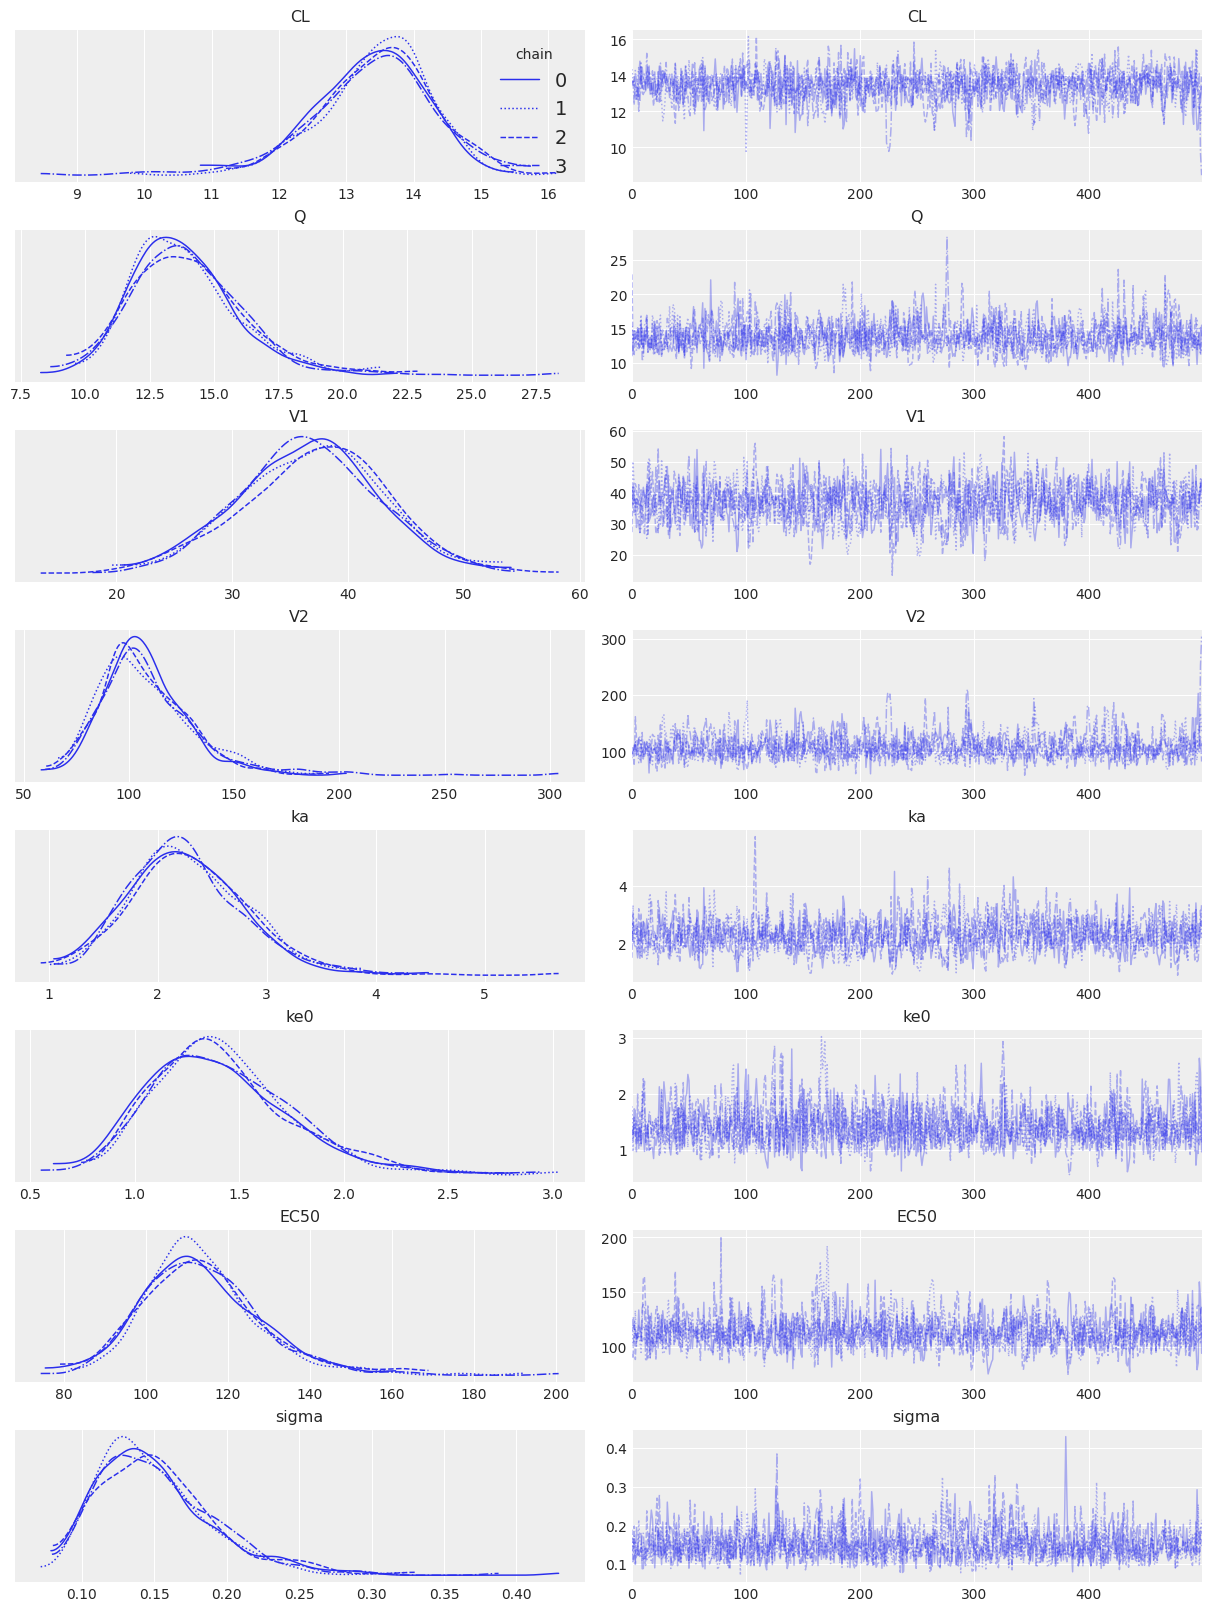

In [61]:
az.plot_trace(fit.posterior, var_names=['CL', 'Q', 'V1', 'V2', 'ka', 'ke0', 'EC50', 'sigma'],
             legend=True);

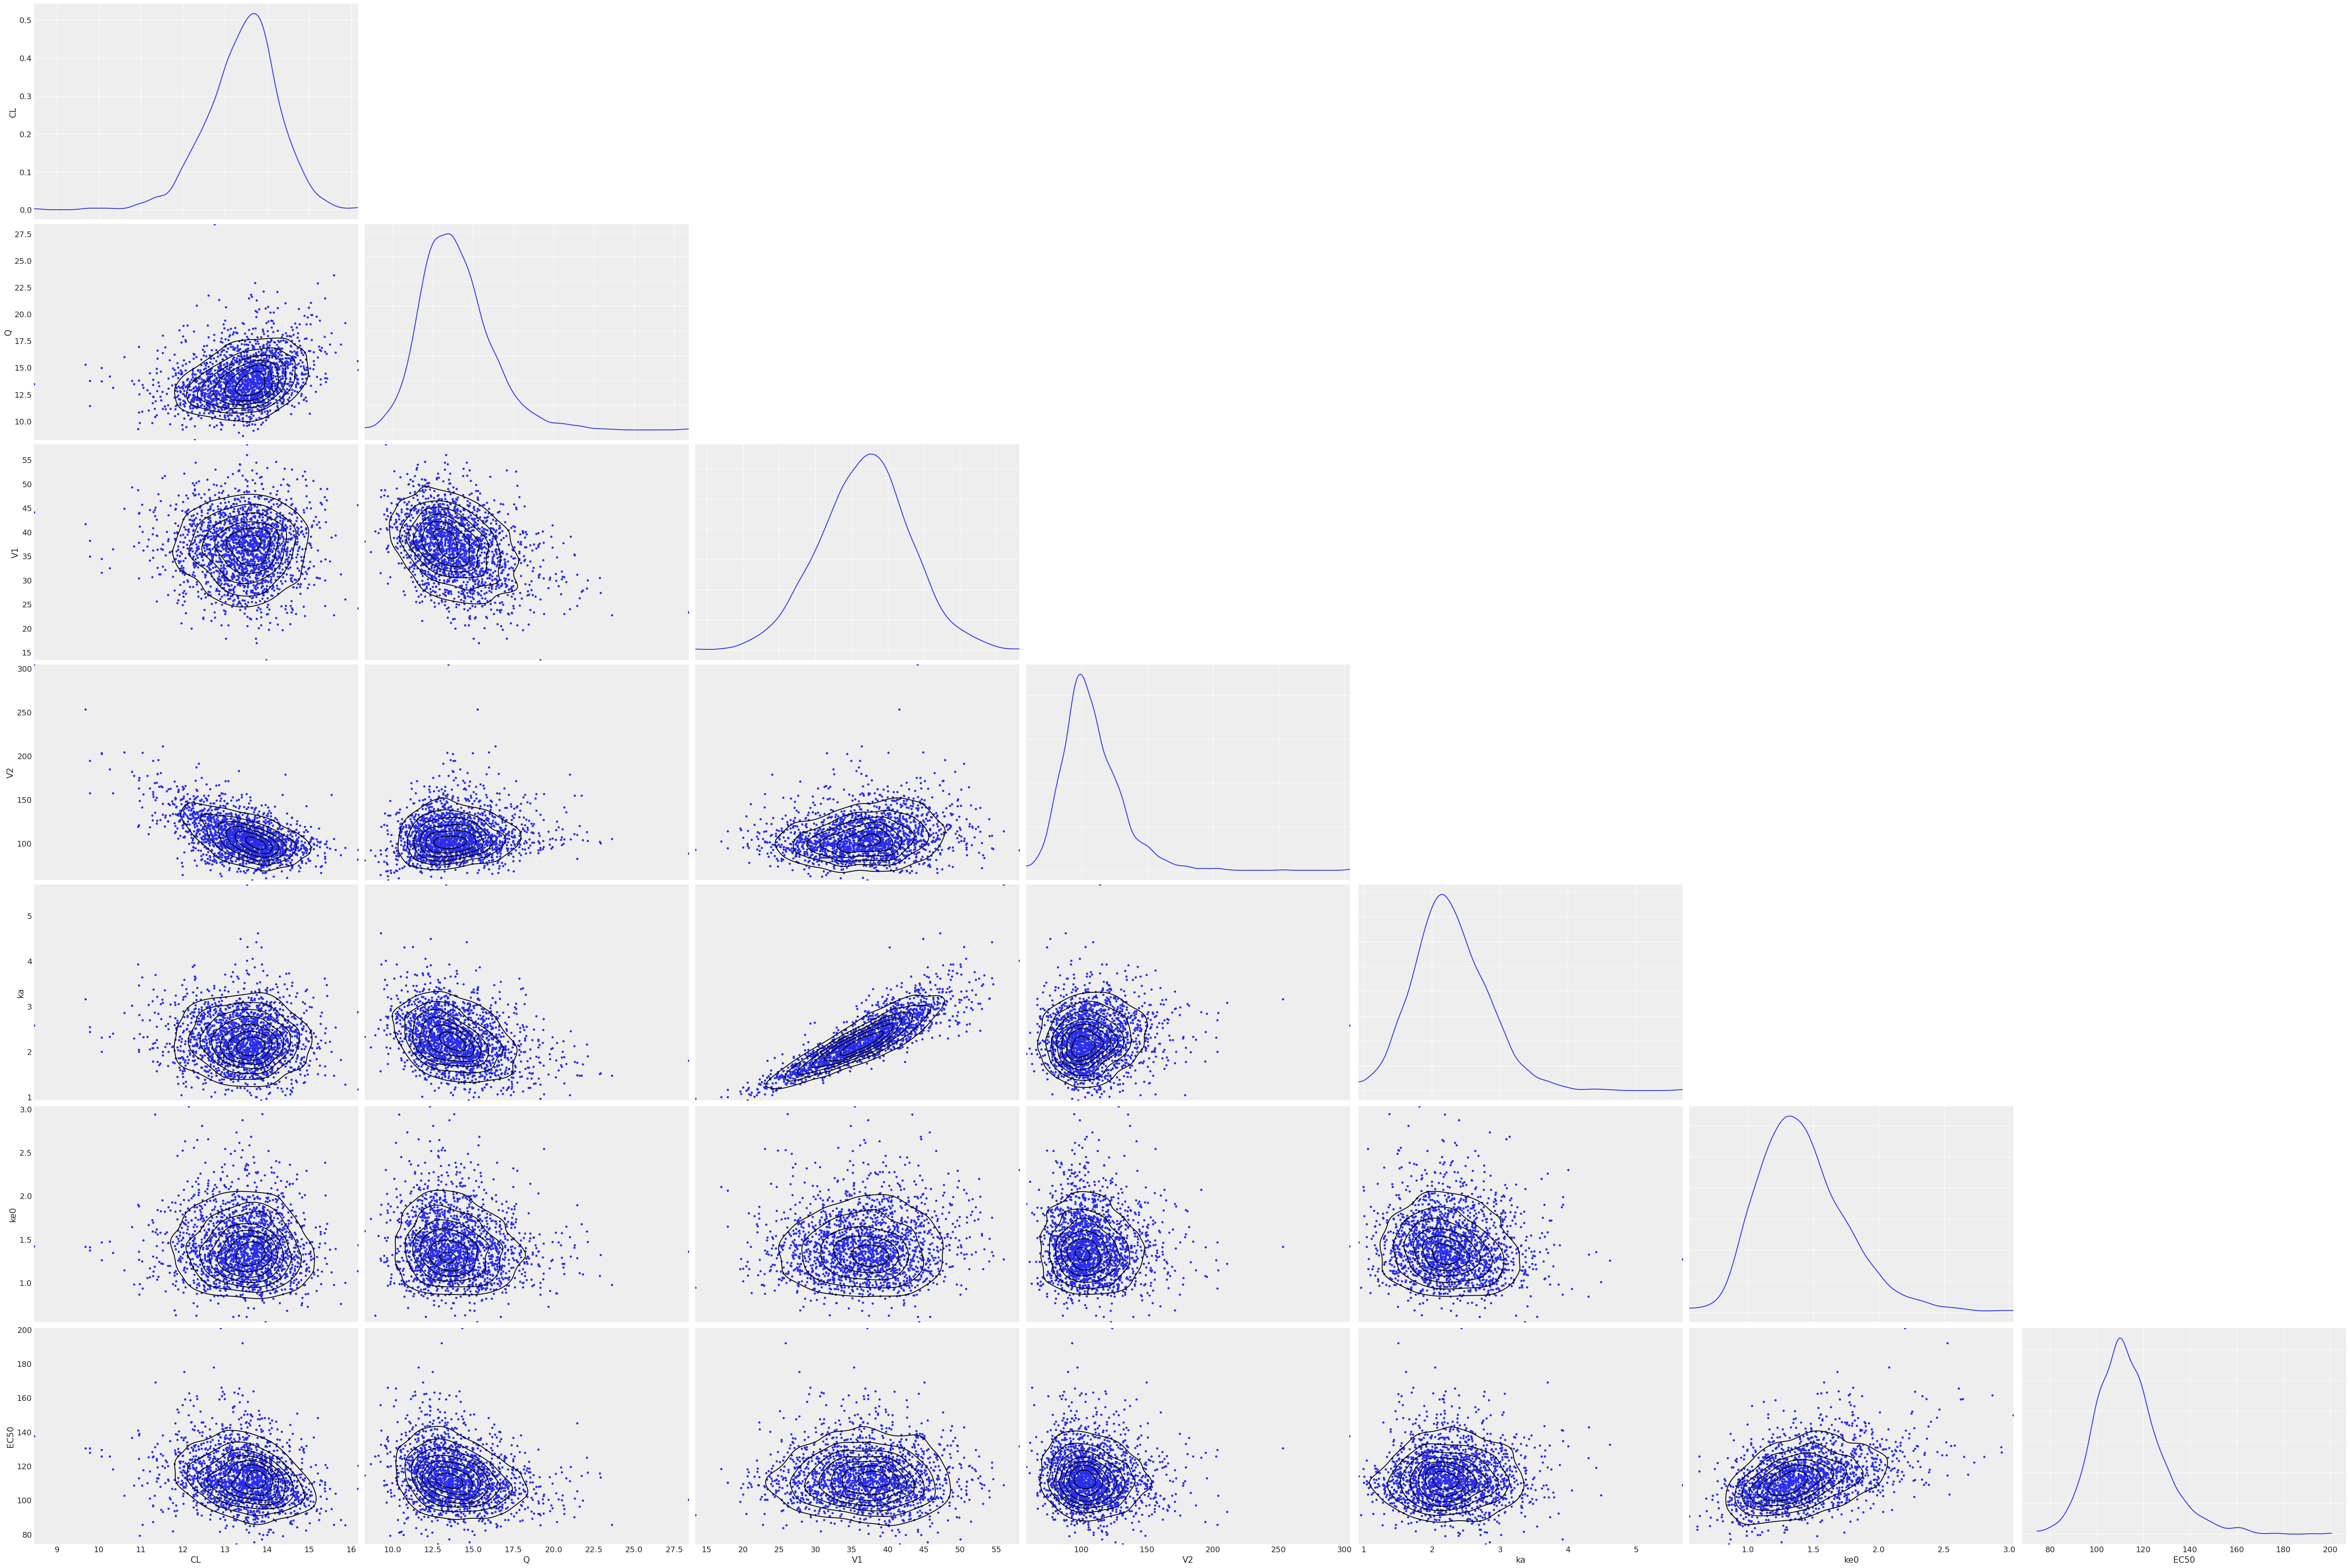

In [62]:
az.plot_pair(fit,
             var_names=['CL', 'Q', 'V1', 'V2', 'ka', 'ke0', 'EC50'], 
             kind=["scatter", "kde"], 
             marginals=True,
            );

## Posterior predictive checks

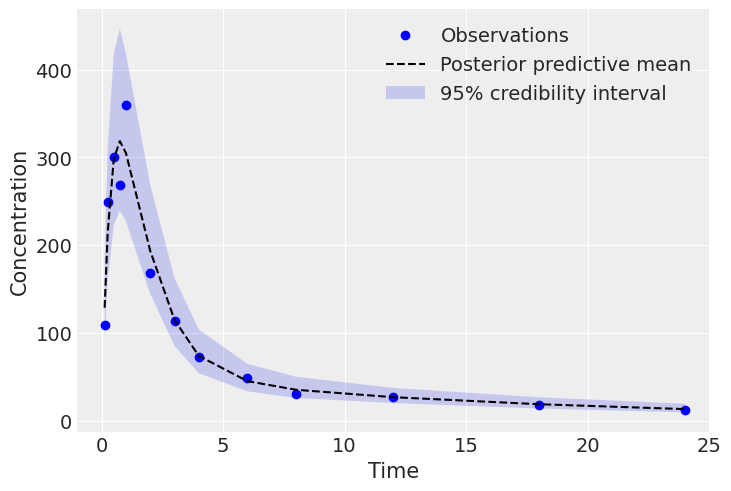

In [63]:
iObs = fit.observed_data['iObs']
t = fit.observed_data['time']
tObs = t[iObs-1]
cObs = fit.observed_data['cObs']
cObsPred = fit.posterior_predictive['cObsPred']

plt.plot(tObs, cObs, 'ob',  label='Observations')
plt.plot(tObs, cObsPred.mean(axis=1).mean(axis=0), '--k', label='Posterior predictive mean')

qlow = np.quantile(cObsPred, 0.05, axis=[0,1])
qhigh = np.quantile(cObsPred, 0.975, axis=[0,1])
plt.fill_between(tObs, qlow, qhigh, alpha=0.2, label='95% credibility interval')

plt.xlim([t[0]-1, t[-1]+1])
plt.ylabel('Concentration')
plt.xlabel('Time')
plt.legend()
plt.show()

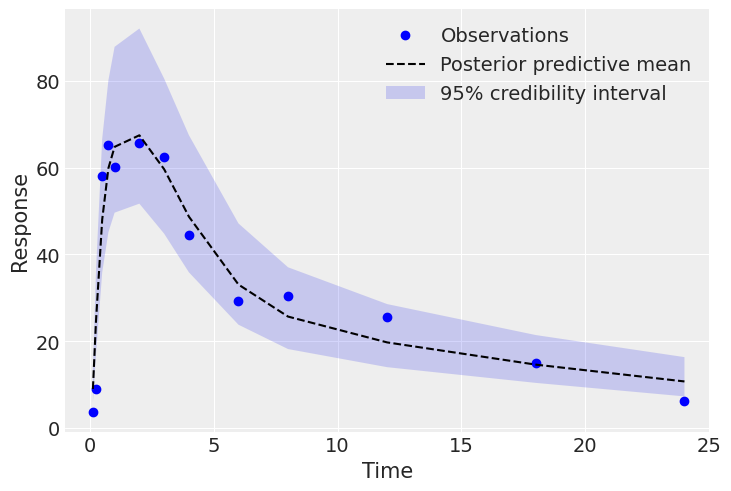

In [64]:
respObs = fit.observed_data['respObs']
respObsPred = fit.posterior_predictive['respObsPred']

plt.plot(tObs, respObs, 'ob',  label='Observations')
plt.plot(tObs, respObsPred.mean(axis=1).mean(axis=0), '--k', label='Posterior predictive mean')

qlow = np.quantile(respObsPred, 0.05, axis=[0,1])
qhigh = np.quantile(respObsPred, 0.975, axis=[0,1])
plt.fill_between(tObs, qlow, qhigh, alpha=0.2, label='95% credibility interval')

plt.xlim([t[0]-1, t[-1]+1])
plt.ylabel('Response')
plt.xlabel('Time')
plt.legend()
plt.show()